# Coding seminar Lesson 3 - calculation, API, Git

In this lesson, we will cover 3 things.

## Agenda
- More calculation of data + streamlining process (codesa are here)
  - _log_ and _exp_, other mathematical functions
  - polynominal fitting
  - process multiple files using `glob`
- Connect your app to external tools via API (on pptx)
  - ChatGPT API
  - Slack API
  - Google Apps Script
- Git (on pptx)

## More calculation

We are going to see more practical case. Suppose you
1. aquired multiple `.csv` files from your measurement.
2. want to run fitting on these data.
3. want to plot the raw and fit data in one panel.
4. want to extract certain parameters, obtained by fitting.
5. want to save the parameters in one file and compare.

Now let's go!

### Read csv file

First let's load `Lesson3_csv/data0.csv` for example. When you open the file, you can see:
1. It has 3 columns
1. Columns are separated by tab (`\t`)
2. First 8 lines are comments and has `#` at the head
These are easy to implement into `numpy.genfromtxt`.

In [76]:
import numpy as np
ar = np.loadtxt('Lesson3_csv/data0.csv', delimiter='\t', comments='#', usecols=[0, 1, 2])
print(ar)

[[ 2.00000e+01  1.00748e+06 -8.57480e+01]
 [ 2.00000e+01  1.02005e+06 -8.72778e+01]
 [ 2.00000e+01  1.02274e+06 -8.92468e+01]
 [ 2.00000e+01  1.02433e+06 -8.92463e+01]
 [ 2.00000e+01  1.05193e+06 -8.79510e+01]
 [ 2.00000e+01  1.08349e+06 -8.72832e+01]
 [ 2.00000e+01  1.07208e+06 -8.70744e+01]
 [ 2.09894e+01  1.02126e+06 -8.55599e+01]
 [ 2.33346e+01  9.04114e+05 -8.82248e+01]
 [ 2.59418e+01  7.99833e+05 -8.70575e+01]
 [ 2.88403e+01  7.27947e+05 -8.72429e+01]
 [ 3.20627e+01  6.73048e+05 -9.04965e+01]
 [ 3.56451e+01  5.53810e+05 -8.53573e+01]
 [ 3.96278e+01  5.39347e+05 -8.74937e+01]
 [ 4.40555e+01  5.00117e+05 -9.02219e+01]
 [ 4.89779e+01  4.00467e+05 -8.68668e+01]
 [ 5.44503e+01  3.74589e+05 -8.65245e+01]
 [ 6.05341e+01  3.53067e+05 -8.70667e+01]
 [ 6.72977e+01  3.20248e+05 -8.80801e+01]
 [ 7.48170e+01  2.89030e+05 -8.70742e+01]
 [ 8.31764e+01  2.61518e+05 -8.77036e+01]
 [ 9.24698e+01  2.31051e+05 -8.58867e+01]
 [ 1.02802e+02  2.13585e+05 -8.59657e+01]
 [ 1.14288e+02  1.89763e+05 -8.671

This is measurement data of [impedance](https://en.wikipedia.org/wiki/Electrical_impedance) spectroscopy of a capacitor.
Of these 3 columns. `data[:,0]` is the frequency $f$ in logarithic manner, `data[:,1]` the impedance $|Z|$, `data[:,2]` the phase $\phi$.

### Fitting
Before we perform fitting, let's check backgrounds.

#### Theoreticacl background
In the impedance measurement, above values are described in the following equation
$$ Z = \frac{1}{j \omega C} = \frac{1}{j \cdot 2 \pi f C} $$
where $Z$ is the impedance, $j$ imaginary number (in electronics we use $j$ instead of $i$, for we use $i$ for the current,) $\omega$ the angular frequency, $f$ the frequency, $C$ the capacitance.
For the simplicity, if we omit the imaginary number $j$, above is transformed to
$$ |Z| = \frac{1}{2 \pi f C} $$
.

#### Fitting process
As for any fitting, linear fitting is easier than complex fitting.
Above equation can be transformed to
$$ \log (|Z|) = - \log (2 \pi C) - \log f $$
, therefore instead of using $y = |Z|$ vs $x = f$, if we use $Y = \log (|Z|)$ vs $X = \log f$, above equation can be rewritten as
$$ Y = - \log (2 \pi C) - X $$
.

Now let's check how this transformation affect the data by plotting.

Text(0.5, 1.0, 'log(|Z|) vs log(f)')

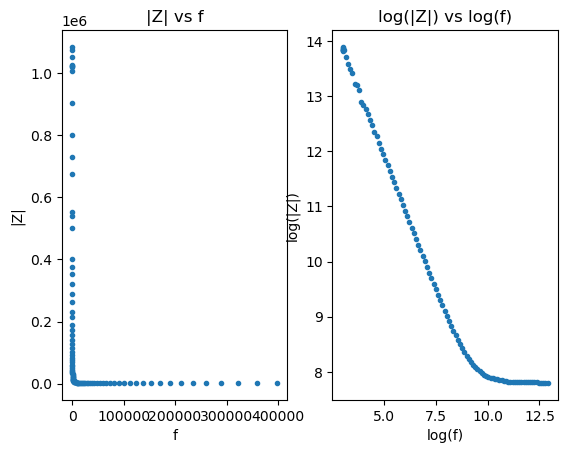

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

_, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(ar[:, 0], ar[:, 1], '.')
ax[0].set_xlabel('f')
ax[0].set_ylabel('|Z|')
ax[0].set_title('|Z| vs f')

x_ = np.log(ar[:, 0])
y_ = np.log(ar[:, 1])

ax[1].plot(x_, y_, '.')
ax[1].set_xlabel('log(f)')
ax[1].set_ylabel('log(|Z|)')
ax[1].set_title('log(|Z|) vs log(f)')

log-log plot gives better view of the data, and we can see that at high $f$, the data is too diverted from linear line.
We can cut off the high $f$ region. How to do so is totally your choice, here let's see how $\phi$ looks like.

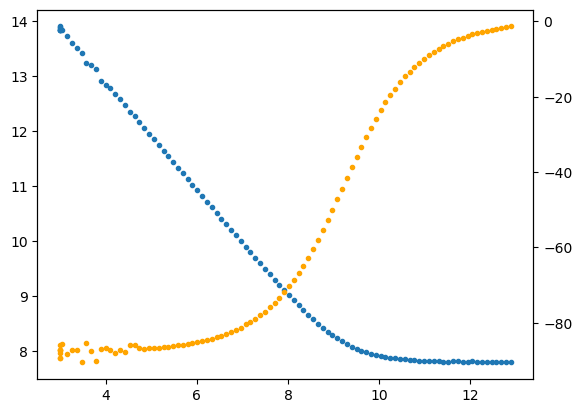

In [78]:
_, ax = plt.subplots()
ax.plot(x_, y_, '.')
ax2 = ax.twinx()
ax2.plot(x_, ar[:, 2], '.', color='orange')

This is totally arbitrary, but let's set that we will fit where $ \phi < -80 $.
Use `numpy` function `where` to get the index where `ar[:, 2]` < `threshold`.

In [79]:
threshold = -80
idx_below_80 = np.where(ar[:, 2] < threshold)[0]
print(idx_below_80)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


### Perform fitting
Python provides several methods for fitting and this case we use [`numpy.polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) that returns an array of coefficients of polynomial function fit to input `y` at point `x` using least square method.

In [80]:
slope, intercept = np.polyfit(x_[idx_below_80], y_[idx_below_80], 1)
print(slope, intercept)

-0.971003378999776 16.75908374454768


`slope` is the slope of the line and it's almost -1. `intercept` is what we want to know, $- \log(2 \pi C)$. Now we can get the $C$ value by:

In [81]:
c = np.exp(-intercept) / 2 / np.pi
print(c)

8.383831469969163e-09


### Plot raw data plus fit line

Let's compare the raw value and fit line by plotting both on the same panel.

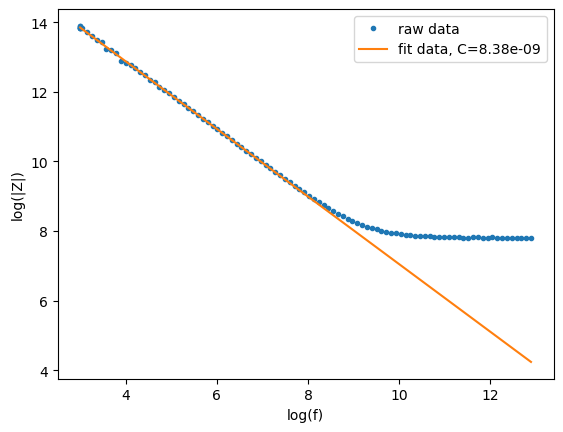

In [82]:
plt.plot(x_, y_, '.', label='raw data')
plt.plot(x_, slope * x_ + intercept, '-', label=f'fit data, C={c:.2e}')
plt.xlabel('log(f)')
plt.ylabel('log(|Z|)')
plt.legend()
plt.show()

### Handle multiple files

Now the process of single file is finished, we want to enhance this to multiple files.
[Activity Diagram](https://plantuml.com/en/activity-diagram-beta) of the process is like below.
(this image is drawn by [PlantUML](https://plantuml.com/en/index). If you'd like to run this part on your PC, you need to import `iplantuml` package by running `%pip install iplantuml` in one cell)

In [ ]:
import iplantuml

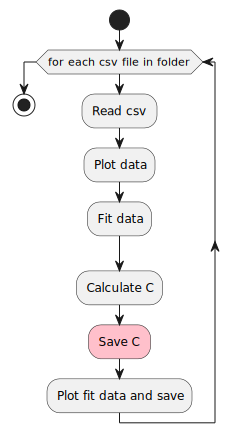

In [83]:
%%plantuml
@startuml
start
while (for each csv file in folder)
    :Read csv;
    :Plot data;
    :Fit data;
    :Calculate C;
    #pink:Save C;
    :Plot fit data and save;
endwhile
stop
@enduml

Note that we have to save $C$ value somewhere else, but all the other parts can be done within a **function**. To simplify, the process will be like this:

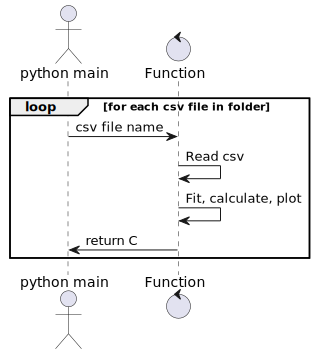

In [84]:
%%plantuml
@startuml
actor "python main" as a
control Function as f

loop for each csv file in folder
    a -> f: csv file name
    f -> f: Read csv
    f -> f: Fit, calculate, plot
    f -> a: return C
end
@enduml

Now let's code this. First, let's make the function part. If you install GitHub Copilot, it quasi-automatically generates **docstring** that is surrounded by '''.

In [85]:
def read_calc_plot(filename: str) -> float:
    '''
    Read csv file, fit data, calculate C, plot data, return c.

    Parameters
    ----------
    filename : str
        single csv file name.

    Returns
    -------
    float
        C value.
    '''

    # read
    ar = np.loadtxt(filename, delimiter='\t', comments='#', usecols=[0, 1, 2])

    # preparation for fitting
    x_ = np.log(ar[:, 0])
    y_ = np.log(ar[:, 1])

    # get fitting range
    idx_below_80 = np.where(ar[:, 2] < threshold)[0]

    # fit
    _, intercept = np.polyfit(x_[idx_below_80], y_[idx_below_80], 1)

    # calculate C
    c = np.exp(-intercept) / 2 / np.pi

    # plot and save image
    plt.plot(x_, y_, '.', label='raw data')
    plt.plot(x_, slope * x_ + intercept, '-', label=f'fit data, C={c:.2e}')
    plt.xlabel('log(f)')
    plt.ylabel('log(|Z|)')
    plt.legend()
    plt.savefig(filename.replace('.csv', '.png'))
    plt.close()

    return c


To obtain all csv file name as a list, `glob` package is useful. To save $C$ value, make a dictionary, using the file name as the key.

<Axes: >

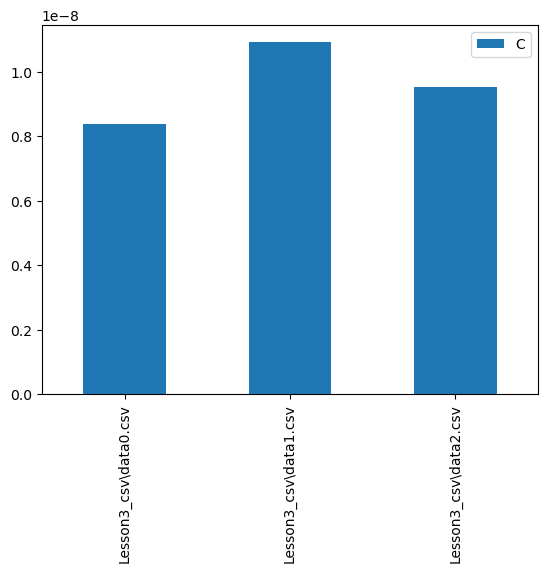

In [86]:
import glob
import pandas as pd

# dic to save all c values
c_dic = {}

# get all csv files in folder
csv_files = glob.glob('Lesson3_csv/*.csv')

# loop over all csv files
for f in csv_files:
    c = read_calc_plot(f)
    # save c value in dic
    c_dic[f] = c

# plot c values and compare
df = pd.DataFrame.from_dict(c_dic, orient='index', columns=['C'])
df.plot(kind='bar')